# Supervised Classification and Regression

## Introduction

`sklearn-raster` can be used to generate predictions from raster data using `scikit-learn` estimators, including supervised classifiers and regressors. In this tutorial, we'll load a built-in dataset with environmental feature rasters and forest structure plot data, train random forest classification and regression models, and predict forest structure attributes from the rasters.

Before continuing, make sure you have the required packages installed with:

```
pip install sklearn-raster[tutorials]
```

## Load Data

This tutorial will generate raster predictions using the southwest Oregon (SWO) USFS Region 6 Ecoplot dataset which contains:

1. **Raster data**: 18 environmental and spectral variables stored in raster format at 30m resolution.
2. **Plot data**: 3,005 plots with environmental, Landsat, and forest cover measurements.

The `load_swo_ecoplot` function fetches and loads raster and tabular data, returning a tuple of raster, feature, and target data. Data is downloaded on-the-fly and cached locally for future use. Image data is stored as a `numpy` array by default, but can be accessed as an `xarray.Dataset` by setting `as_dataset=True`. We'll start by loading the dataset and exploring each component.

In [1]:
from sklearn_raster.datasets import load_swo_ecoplot

X_img, X, y = load_swo_ecoplot(as_dataset=True)

### Raster Data

Inspecting the raster data reveals a 128 x 128 dataset with 18 bands representing climate, topographic, and spectral features. Loading with `large_rasters=True` would return a larger 2048 x 4096 dataset, but we'll stick with the smaller demo dataset to keep things fast.

In [2]:
X_img.data_vars

Data variables:
    ANNPRE   (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    ANNTMP   (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    AUGMAXT  (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    CONTPRE  (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    CVPRE    (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    DECMINT  (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    DIFTMP   (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    SMRTMP   (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    SMRTP    (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    ASPTR    (y, x) uint8 16kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    DEM      (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    PRR      (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    SLPPCT   (y, x) int16 33kB dask.

Let's plot a few bands to visualize the data, normalizing to get them in the same colorscale.

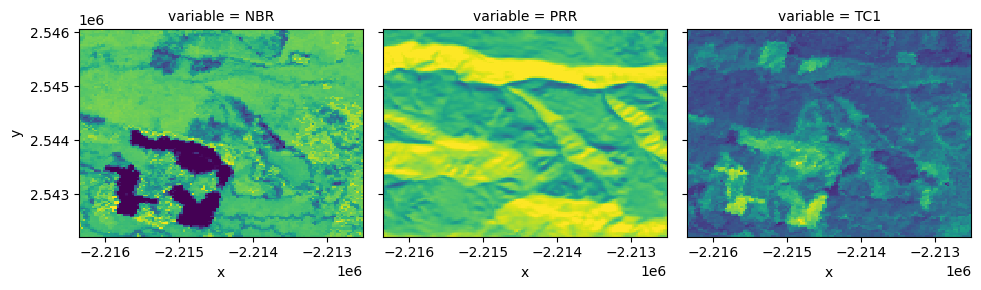

In [3]:
# Load normalized burn ratio, potential relative radiation, and tasseled cap brightness
preview = X_img[["NBR", "PRR", "TC1"]]
(preview / preview.max()).to_dataarray().plot(
    col="variable", add_colorbar=False, robust=True
)

### Plot Data

The second component is a dataframe of feature data, representing 3,005 plots with predictors that correspond to each of the raster bands.

In [4]:
X.head()

,ANNPRE,ANNTMP,AUGMAXT,CONTPRE,CVPRE,DECMINT,DIFTMP,SMRTMP,SMRTP,ASPTR,DEM,PRR,SLPPCT,TPI450,TC1,TC2,TC3,NBR
52481,740.0000,514.6667,2315.0000,517.6667,8971.6667,-583.1111,2899.1111,1136.1111,212.2222,197.6667,1870.1111,13196.6667,48.3333,33.7778,218.7778,68.5556,-86.2222,343.5556
52482,742.0000,563.5556,2354.3333,502.0000,9124.3333,-543.5556,2898.8889,1179.4444,221.1111,190.2222,1713.1111,16355.7778,5.4444,6.4444,210.2222,60.3333,-96.6667,261.6667
52484,738.5556,639.1111,2468.8889,545.8889,8897.2222,-479.1111,2949.0000,1266.2222,236.0000,194.5556,1612.1111,15132.5556,15.5556,-1.2222,157.0000,110.2222,-17.4444,721.0000
52485,730.3333,622.6667,2405.3333,555.0000,8829.7778,-481.2222,2887.5556,1244.2222,234.0000,196.4444,1682.3333,15146.6667,19.8889,-16.8889,152.5556,86.1111,-31.6667,597.1111
52494,720.0000,778.5556,2678.1111,658.5556,8638.0000,-386.6667,3065.7778,1396.0000,262.0000,191.7778,1345.6667,16672.1111,2.0000,0.4444,214.6667,58.5556,-88.1111,294.2222


The final component is a dataframe of target data, with canopy cover measurements by species for each of the 3,005 plots.

In [5]:
y.head()

,ABAM_COV,ABGRC_COV,ABPRSH_COV,ACMA3_COV,ALRH2_COV,ALRU2_COV,CADE27_COV,CHCH7_COV,CHLA_COV,LIDE3_COV,...,PIPO_COV,PISI_COV,PSME_COV,QUCH2_COV,QUGA4_COV,QUKE_COV,TABR2_COV,THPL_COV,TSHE_COV,UMCA_COV
52481,0.0,0.0000,39.3469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52482,0.0,0.0000,10.4166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52484,0.0,47.7954,25.9182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52485,0.0,0.0000,42.3050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52494,0.0,0.0000,2.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Predicting Forest Structure

### Canopy Cover Regression

Since the target data represent continuous cover measurements for multiple species, we'll start by building a multi-output regression model. The model is instantiated as normal, then wrapped into a `FeatureArrayEstimator` with the `wrap` method prior to fitting.

In [6]:
from sklearn.ensemble import RandomForestRegressor

from sklearn_raster import wrap

reg = wrap(RandomForestRegressor(n_estimators=50, random_state=42))
reg.fit(X, y)

FeatureArrayEstimator(wrapped_estimator=RandomForestRegressor(n_estimators=50,
                                                              random_state=42))

Passing the feature raster into `predict` will generate a raster output with one band for each target variable in `y`.

In [7]:
pred = reg.predict(X_img)
pred.data_vars

Data variables:
    ABAM_COV    (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    ABGRC_COV   (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    ABPRSH_COV  (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    ACMA3_COV   (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    ALRH2_COV   (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    ALRU2_COV   (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    CADE27_COV  (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    CHCH7_COV   (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    CHLA_COV    (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    LIDE3_COV   (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    NOTALY_COV  (y, x) float64 131kB dask.array<chunksize=(13, 13), meta=np.ndarray>
    PIBR_COV    (y, x) float64 131kB dask.array<c

Plotting a few of the output bands shows estimated canopy cover for the corresponding species.

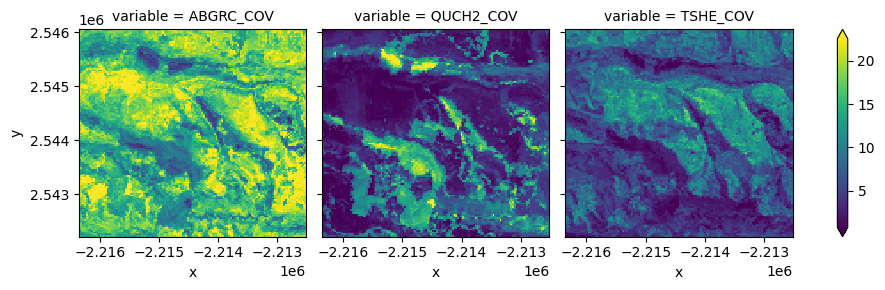

In [8]:
pred[["ABGRC_COV", "QUCH2_COV", "TSHE_COV"]].to_dataarray().plot(
    col="variable", add_colorbar=True, robust=True
)

### Shannon Diversity Classification

To turn this into a classification problem, we can use the relative cover of each species to calculate the [Shannon diversity index](https://en.wikipedia.org/wiki/Diversity_index#Shannon_index) as a metric of species richness at each plot, and bin that into ordinal integer labels from low to high diversity.

In [9]:
import numpy as np
import pandas as pd

proportions = y.divide(y.sum(axis=1), axis=0)
diversity = -(proportions * np.log(proportions + 1e-10)).sum(axis=1)
y_clf = pd.qcut(diversity, 5, labels=False).rename("diversity")

y_clf.value_counts()

diversity
0    601
1    601
3    601
2    601
4    601
Name: count, dtype: int64

Now we can instantiate, wrap, and fit a classification model to predict the Shannon diversity bin.

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = wrap(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X, y_clf)

FeatureArrayEstimator(wrapped_estimator=RandomForestClassifier(random_state=42))

Calling `predict` will classify each pixel in the feature raster, creating a map with the predicted species diversity, from low to high.

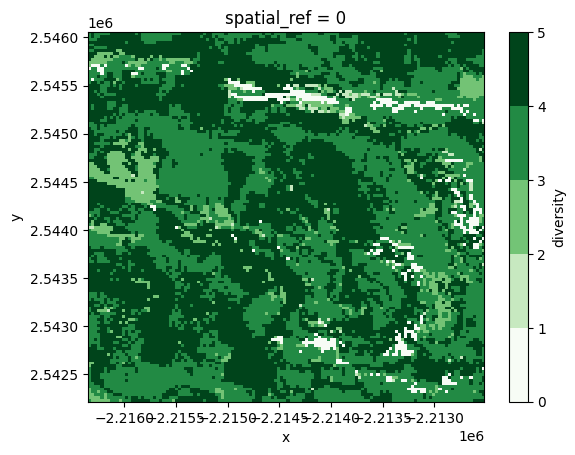

In [11]:
clf_pred = clf.predict(X_img)
clf_pred["diversity"].plot.imshow(cmap="Greens", levels=6, vmin=0, vmax=5)

Wrapped classifiers also implement the `predict_proba` method, returning the probability of each class. Below, we can plot the probability of class 4, the highest diversity bin.

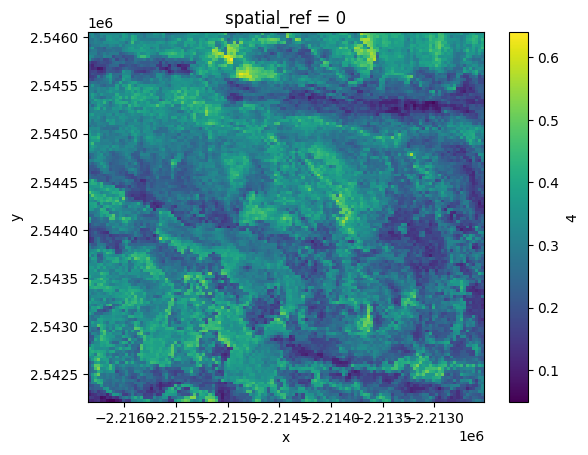

In [12]:
clf.predict_proba(X_img)[4].plot()